# Introduction of analog Hamiltonian simulation

Analog Hamiltonian Simulation (AHS) is a different paradigm of quantum computing compared to the gate-based quantum computing. The idea of AHS is to use a well-controlled quantum system and engineer its interaction to mimic the dynamics of the Hamiltonian of the quantum system in question. 

In the gate-based quantum computation, the program is a quantum circuit consisting of a series of quantum gates, each of which acts only a small subset of qubits. In contrast, an AHS program is one or a sequence of time-dependent Hamiltonians that govern the time evolution of all the qubits. The comparison can be seen in the following figure (Source: <a href="https://arxiv.org/abs/2006.12326">Henriet et al.</a>), where the left side shows a typical quantum circuit, and the right side illustrates that, during AHS, the effect of the evolution under a Hamiltonian can be understood as a unitary acting simultaneously on all qubits.

![Comparison_AHS.png](Comparison_AHS.png)

In this notebook, we focus on running Analog Hamiltonian Simulations with Rydberg atoms. 

# AHS with Rydberg atoms

An Analog Hamiltonian Simulation **program** is fully specified by its quantum register and (time-dependent) Hamiltonian.

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

In order to run AHS program with Rydberg atoms, we will first have to understand what type of Hamiltonian can the Rydberg atoms simulate.

## Introduction to Rydberg Hamiltonian

Depending on the atomic states we use for the Rydberg system, its Hamiltonian could take different forms. Here we shall focus on the following type of Hamiltonian

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{k=1}^N H_{\text{shift}, k}(t) + \sum_{j=1}^N\sum_{k = j}^N H_{\text{vdW}, j, k},
\end{align}

where $j, k=1,2,\ldots N$ index the atoms in the program register. We describe the nature and effect of each term in the following sections.

### Register

First, we need to define a quantum **register** on which this Hamiltonian will act: a 2-dimentional layout of neutral atoms.

In [2]:
import numpy as np

# e.g. two atoms separated by 5.5 micrometers
a = 5.5e-6

register.add([0, 0])
register.add([a, 0.0]);

The atom arrangement can be visualized in the following way

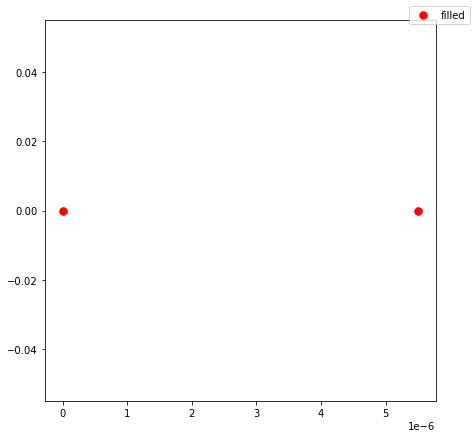

In [3]:
from utils import show_register

show_register(register)

### Driving field

The first term of the Hamiltonian represents the effect of a **driving field** that addresses the atoms simultaneously and uniformly

\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}\sigma_k + e^{-i\phi(t)}\sigma_k^\dagger\right) - \Delta_\text{global}(t)n_k,
\end{align}

where $\Omega$, $\phi$, and $\Delta_\text{global}$ to denote the **amplitude** (Rabi frequency), laser **phase**, and the **detuning** of the driving laser field. Here $\sigma_k = |g_k\rangle\langle r_k|$ is the lowering operator, and $n_k = |r_k\rangle\langle r_k|$ is the number operator of atom $k$; the kets $|g_k\rangle$ and $|r_k\rangle$ denote the ground and Rydberg states, respectively. The $\Omega$ part of the driving term is identical to a uniform (time-dependent) _transverse_ magnetic field, whereas the $\Delta_\text{global}$ part implements the effect of a _longitudinal_ magnetic field, in a spin-model representation.

In [4]:
from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

# e.g. trapzoid amplitude time series
Omega_max = 2.5e6  # rad / s

# e.g. the duration of the program
# (We will explain the duration for this example in the next section)
t_max = np.pi/(np.sqrt(2)*Omega_max) # s 

# e.g. constant Rabi frequency
Omega = TimeSeries()
Omega.put(0.0, Omega_max)
Omega.put(t_max, Omega_max)

# e.g. all-zero phase and detuning
phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad/s])
Delta_global = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta_global
)

H += drive

### Shifting field

The second term in $H(t)$ represents the effect of a **shifting field** that detunes atoms according to a non-uniform pattern.
\begin{align}
H_{\text{shift}, k}(t) = -\Delta_\text{local}(t)h_k \,n_k,
\end{align}

where $\Delta_\text{local}(t)$ is the time-dependent **magnitude** of the frequency shift, and $h_k$ is the atom-dependent **pattern**, which is a dimensionless number between 0 and 1. This shifting term is identical to a non-uniform (and time-dependent) _longitudinal_ magnetic field in a spin-model representation.


In [5]:
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField

# e.g. triangular magnitude time series
Delta_local = TimeSeries().put(0.0, 0.0).put(t_max /2, 2e7).put(t_max, 0.0)

# For simplicity of this example, we set the patterns to be 0 for
# the pair of atoms. In general, pattern could take any value
# between 0 and 1
pattern = Pattern([0, 0])

shift = ShiftingField(
    magnitude=Field(
        time_series=Delta_local,
        pattern=pattern
    )
)

H += shift

The driving field and the shifting field can be inspected with the following utility function

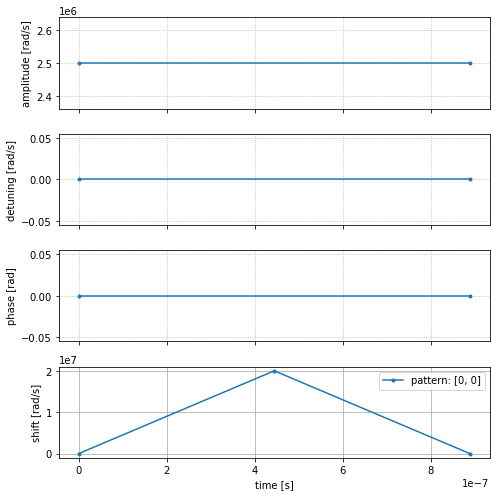

In [6]:
from utils import show_drive_and_shift

show_drive_and_shift(drive, shift)

### Rydberg-Rydberg interaction

Finally, the third term in $H(t)$ is the van de Waals interaction between all pairs of Rydberg atoms,

\begin{align}
H_{\text{vdW}, j, k} =V_{jk} \,n_j\, n_k = \frac{C_6}{R_{j,k}^6} \,n_j\, n_k,
\end{align}

where $C_6$ is a fixed interaction coefficient, and $R_{j,k}=|{\bf x}_j-{\bf x}_k|$ is the distance between atoms $j$ and $k$. This interacting shifts the frequency of the Rydberg level of all atoms that are close to an atom that is already in its Rydberg state. While the overall coefficient, $C_6$ is a fixed value (determined by the nature of the ground and Rydberg states), the strength of this interaction can be tuned by adjusting the pairwise distance $R_{j,k}$ between atoms.

**Introduction to Rydberg blockade**

For the interaction coefficient, the value of $C_6$ depends on the atom species, and the states used in the simulation. Here we shall take the value 
\begin{align}
C_6 = 5.42\times 10^{-24} \text{rad} m^6/s
\end{align}
for $|r\rangle = |70S_{1/2}\rangle$ of the $^{87}$Rb atoms. For the typical scenario, where atoms are separated by $4\times10^{-6}$ meters, the Van del Waals interaction reads $V_{jk}=1.32\times10^9 \text{rad}/s$, which is much larger than the typical scale of the Rabi frequency (around $6\times10^6 \text{rad}/s$). As a result, when the separation of two atoms is within certain distance, it is nearly impossible to drive them to the Rydberg state simultaneously. 

This is called the Rydberg blockade phenomena, illustrated in the figure below (Source: [Browaeys and Lahaye](https://arxiv.org/abs/2002.07413)), where $R$ is the separation between the atoms, and $E$ indicates the energies or frequencies of the different two-atom states as $R$ changes. The vertical arrows indicate the effect of a uniform driving field (of with Rabi frequency $\Omega$) that successfully transitions the atoms from the $|gg\rangle$ ground state to the 1-atom excited state $|\psi_+\rangle = (|gr\rangle + |rg\rangle)/\sqrt{2}$ (independent of $R$), but fails to get from there to the doubly-excited state $|rr\rangle$, if $R$ is smaller than $R_b = (C_6 / \Omega)^{1/6}$, the blockade radius.

<img src="Blockade.png" alt="drawing" style="width:250px;"/>

In [7]:
# Note:
# The van der Waals interaction term is implicitly assumed in the current version of the AHS module,
# its strength (C6 / R_{j,k}^6) is calculated (if using the local simulator) from the atomic positions 
# of the register, hence there is no need to specify it explicitly.

### Full program

The fully-specified program can be inspected with the following command.

In [8]:
ahs_program.to_ir().dict()

{'braketSchemaHeader': {'name': 'braket.ir.ahs.program', 'version': '1'},
 'setup': {'atomArray': {'sites': [[Decimal('0'), Decimal('0')],
    [Decimal('0.0000055'), Decimal('0.0')]],
   'filling': [1, 1]}},
 'hamiltonian': {'drivingFields': [{'amplitude': {'sequence': {'values': [Decimal('2500000.0'),
       Decimal('2500000.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'phase': {'sequence': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'detuning': {'sequence': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'}}],
  'shiftingFields': [{'magnitude': {'sequence': {'values': [Decimal('0.0'),
       Decimal('20000000.0'),
       Decimal('0.0')],
      'times': [Decimal('0.0'),
       Decimal('4.442882938158366E-7'),
       Decimal('8.88576587631673

# Runing AHS program with local simulator

The AHS program defined above realizes the maximally entangled state for the pair of atoms. To see that, recall that the shifting field is set to zero, and the only nonzero driving field is the Rabi frequency with $\Omega(t)=\Omega_\text{max}=2.5\times10^6$ rad/s throughout the evolution. Hence the Hamiltonian reads
\begin{align}
H(t) = \frac{\Omega_\text{max}}{2}\sum_{k=1}^2\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) + V_{12}{n}_1{n}_2,
\end{align}
where $k=1,2$ are the indices of the atoms. More concretely, in the basis of $\left\{|gg\rangle, |gr\rangle, |rg\rangle, |rr\rangle\right\}$, the Hamiltonian takes the following matrix representation
\begin{align}
H(t) = 
\begin{bmatrix}
0 & \frac{\Omega(t)}{2} & \frac{\Omega(t)}{2} & 0 \\
\frac{\Omega(t)}{2} & 0 & 0 & \frac{\Omega(t)}{2}\\
\frac{\Omega(t)}{2} & 0 & 0 & \frac{\Omega(t)}{2}\\
0 & \frac{\Omega(t)}{2} & \frac{\Omega(t)}{2} & V_{12}
\end{bmatrix}.
\end{align}
Since the two atoms are separated by $5.5\times10^{-6}$ meters, the interaction strength between them reads
\begin{align}
V_{12}=\frac{C_6}{R_{12}^6} = \frac{5.42\times10^{-24}}{(5.5\times10^{-6})^6}\approx1.96\times10^8 \text{ rad/s},
\end{align}
which is much greater than the Rabi frequency. Hence the two atoms are in the Rydberg blockade regime, and the state $|rr\rangle$ is very unlikely to be excited (assuming the initial state is $|gg\rangle$). Hence we can neglect the $|rr\rangle$ state, and the Hamiltonian is simplified to be
\begin{align}
H(t) = 
\begin{bmatrix}
0 & \frac{\Omega(t)}{2} & \frac{\Omega(t)}{2} \\
\frac{\Omega(t)}{2} & 0 & 0 \\
\frac{\Omega(t)}{2} & 0 & 0 
\end{bmatrix},
\end{align}
and the final state of the evolution can be solved to be
\begin{align}
|\psi\rangle = e^{iH(t)t}|gg\rangle = 
\begin{bmatrix}
\cos\frac{\Omega t}{\sqrt{2}}\\
\frac{i}{\sqrt{2}}\sin\frac{\Omega t}{\sqrt{2}}\\
\frac{i}{\sqrt{2}}\sin\frac{\Omega t}{\sqrt{2}}
\end{bmatrix}.
\end{align}
Hence if the system evolves for a duration $T=\frac{\pi}{\sqrt{2}\Omega}$, which is indeed the duration of the AHS program defined in the previous section, we will arrive at a maximally entangled state between the two atoms
\begin{align}
|\psi\rangle = \frac{1}{\sqrt{2}}(|gr\rangle+|rg\rangle).
\end{align}

Before submitting the AHS program to a QPU, it is useful to run the program on the local simulator to check if the simulation result meets one's expectation. 

In [9]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

We can run the AHS program just like running a quantum circuit on other Braket devices

In [10]:
result = device.run(ahs_program, shots=1000).result()

To confirm that we indeed arrive at a maximally entangled state, we first collect the measurement results, followed by counting the number of occurence of $|gr\rangle$ and $|rg\rangle$ respectively.

In [11]:
def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]

    counters = {}
    for post_sequence in post_sequences:
        if str(post_sequence) in counters:
            counters[str(post_sequence)] += 1
        else:
            counters[str(post_sequence)] = 1
    return counters

get_counters_from_result(result)

{'[1, 0]': 513, '[0, 1]': 487}

Indeed, this shows that the AHS program outputs a maximally entangled state for the two atoms, up to measurement fluctuation, as desired. Since we know *a priori* that the $|rr\rangle$ can be neglected from the simulation, we can reduce the size of the Hilbert space by setting the value of `blockade_radius` in the local simulator

In [12]:
result_blockade = device.run(ahs_program, shots=1000, blockade_radius=a).result()
get_counters_from_result(result_blockade)

{'[1, 0]': 477, '[0, 1]': 523}

We see that the simulation within the truncated Hilbert space gives the same outcome, as expected. For AHS program with large number of atoms, truncating the Hilbert space with appropriately chosen blockade radius will significantly speed up the simulation while maintaining the accuracy of the simulation outcome.

In [13]:
# Note:
# The local simulator uses the `scipy.integrate.ode` behind the scene, 
# and accept the following parameters
#
# atol: bool = 1e-8,
# rtol: bool = 1e-6,
# solver_method: str = "adams",
# order: int = 12,
# nsteps: int = 1000,
# first_step: int = 0,
# max_step: int = 0,
# min_step: int = 0,

In summary, in this notebook, we have introduced the analog Hamiltonian simulation (AHS), a different quantum computing paradigm, and how to run AHS program with Rydberg atoms. We have also demonstrated how to run AHS program with the local simulator on Braket.